In [1]:
!git clone git@github.com:facebookresearch/vggt.git

Cloning into 'vggt'...
remote: Enumerating objects: 1265, done.
remote: Total 1265 (delta 0), reused 0 (delta 0), pack-reused 1265 (from 1)
Receiving objects: 100% (1265/1265), 64.94 MiB | 9.39 MiB/s, done.
Resolving deltas: 100% (579/579), done.


In [1]:
!mv vggt/vggt/* vggt/

mv: cannot stat 'vggt/vggt/*': No such file or directory


In [1]:
import torch

from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images

device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 

# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from pathlib import Path

from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import os
import torch

dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

class SingleImageDataset(Dataset):
    """
    Each image is treated as a separate scene.
    Returns a tensor [1, 3, H, W] so VGGT sees one view per scene.
    """
    def __init__(self, image_dir, device=None, dtype=torch.float32):
        self.image_paths = [str(Path(image_dir) / f)
                            for f in os.listdir(image_dir)
                            if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        self.device = device
        self.dtype = dtype

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        # your existing preprocessing (returns [3, H, W])
        img = load_and_preprocess_images([img_path])[0]
        img = img.unsqueeze(0)          # → [1, 3, H, W]  (1 view)
        if self.device is not None:
            img = img.to(self.device, dtype=self.dtype)
        else:
            img = img.to(dtype=self.dtype)
        return img

dataset = SingleImageDataset(
    image_dir="data/images/mock_label",   # path containing subfolders for each scene
    device=device,
    dtype=dtype,
)

loader = DataLoader(
    dataset,
    batch_size=10,       # number of scenes per batch
    shuffle=False,
)

In [3]:

i = 0
all_tokens = []
for batch in loader:
    print(batch.shape)  # [B, S, 3, H, W]
    with torch.no_grad():
        aggregated_tokens_list, patch_start_idx = model.aggregator(batch)
        all_tokens.append(aggregated_tokens_list[-1])

    if i >= 10:
        break

    i += 1

torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])


In [86]:
all_imgs = torch.cat(all_tokens, dim=0)
all_imgs.shape
all_imgs = all_imgs[:,:,5:,:]

In [91]:
flattened = all_imgs.mean(dim=2).squeeze()
print(flattened.shape)

# Normalize to unit length (cosine similarity)
flattened = flattened / flattened.norm(dim=1, keepdim=True)

# Cosine similarity matrix [N x N]
similarities = flattened @ flattened.T

torch.Size([110, 2048])


In [92]:
idx = torch.arange(len(similarities))
similarities[idx, idx] = 0

In [93]:
similarities.argmax(dim=1)

tensor([ 83,  92,  92,  99,  64,   8,  18,  40,  40,  64,  85,  44,  75,  80,
          2,  27,  23,  35,   6,  82,  49,  19,  30,  16,  50,  48,  64,  53,
         97,  97,  69,  83,  84, 105,  77,  17,  98,  91,  41,  64,   8,  38,
         69,  16,  70,   1,  42,  76,  94,  89,  24,  33,  54,  91,  52, 103,
         60,  69, 103,  90,  76,  85,  46,  50,  26,  61,  90,  13,  15,  42,
         64, 108, 104,   9,  54,  12,  88,  39, 100,  23,  13,  75,  19,  31,
         32,  90,  59,  73,  76, 100,  85,  53,   1,  68,  48,  90,  20,  28,
         77,   3,  78,  53,  17,  55,  97,  33,  27,  26,  71,  89],
       device='cuda:0')

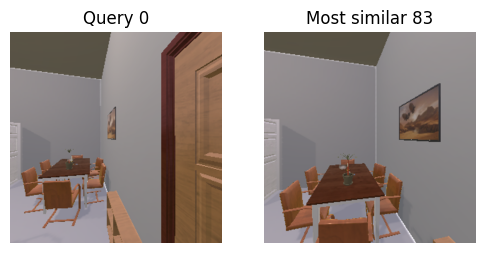

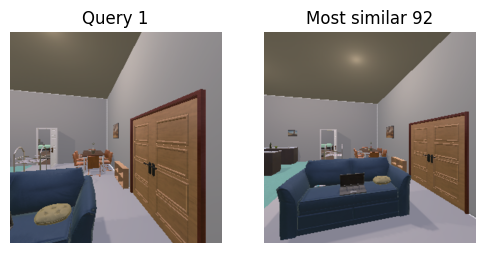

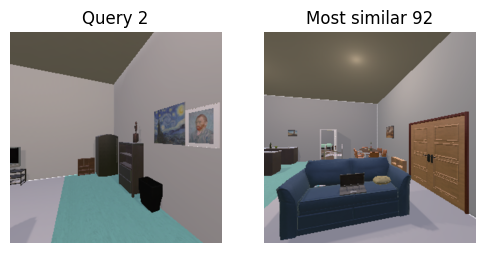

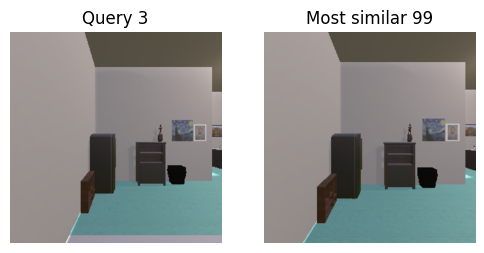

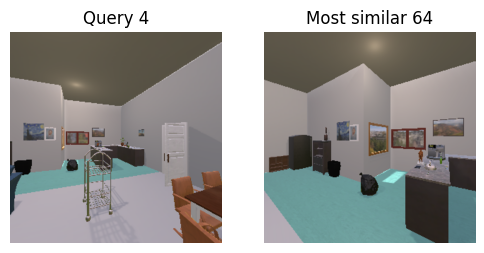

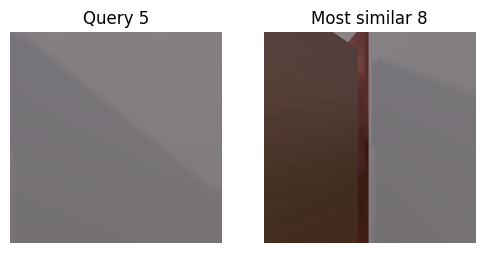

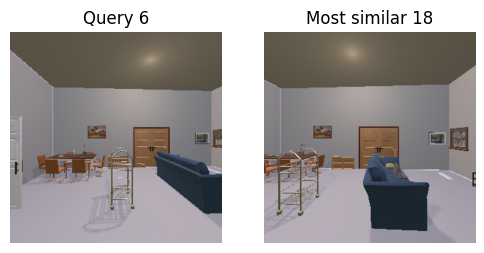

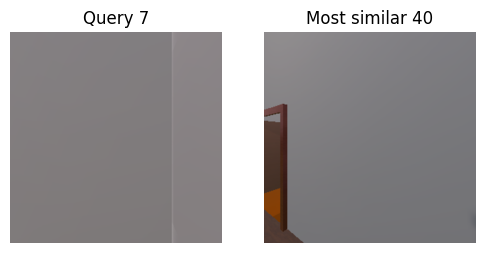

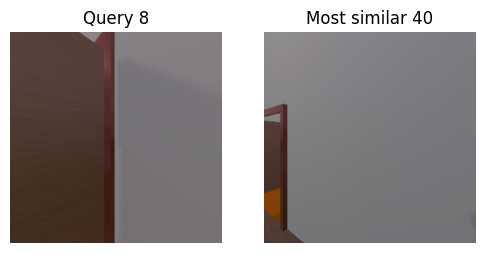

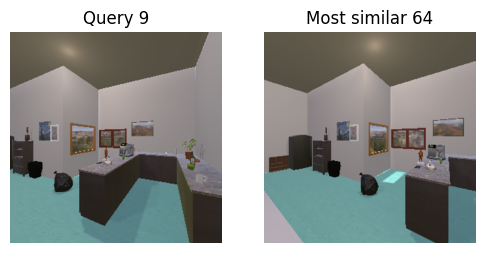

In [94]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

similarities_no_self = similarities.clone()
similarities_no_self.fill_diagonal_(-float("inf"))
top_idx = similarities_no_self.argmax(dim=1)  # [N] -> index of best match

for i in range(min(10, len(dataset))):
    j = top_idx[i].item()  # most similar image index

    # get both tensors from dataset
    img_i = dataset[i][0].squeeze(0).detach().cpu().type(torch.float)  # [3, H, W]
    img_j = dataset[j][0].squeeze(0).detach().cpu().type(torch.float)

    # convert to PIL (assumes images are normalized [0,1])
    pil_i = to_pil_image(img_i)
    pil_j = to_pil_image(img_j)

    # show side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(pil_i); axes[0].set_title(f"Query {i}"); axes[0].axis("off")
    axes[1].imshow(pil_j); axes[1].set_title(f"Most similar {j}"); axes[1].axis("off")
    plt.show()

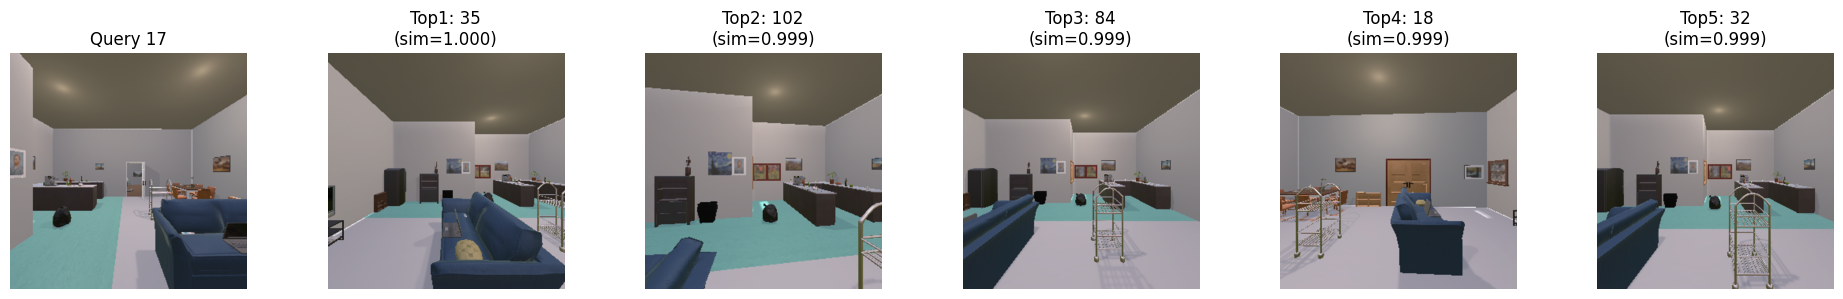

In [ ]:

query_idx = 17         # which image you want to use as query
k = 5                  # number of most similar images to show

# clone and mask self-similarity
similarities_no_self = similarities.clone()
similarities_no_self.fill_diagonal_(-float("inf"))

# get the top-k most similar indices for the chosen query
topk_scores, topk_idx = similarities_no_self[query_idx].topk(k)

# retrieve and convert the query image
img_query = dataset[query_idx][0].squeeze(0).detach().cpu().to(dtype=torch.float)
pil_query = to_pil_image(img_query)

# plot query + its top-k matches
fig, axes = plt.subplots(1, k + 1, figsize=(3.2*(k+1), 3))
axes[0].imshow(pil_query)
axes[0].set_title(f"Query {query_idx}")
axes[0].axis("off")

for n, (idx, score) in enumerate(zip(topk_idx, topk_scores), start=1):
    img = dataset[idx.item()][0].squeeze(0).detach().cpu().to(dtype=torch.float)
    pil_img = to_pil_image(img)
    axes[n].imshow(pil_img)
    axes[n].set_title(f"Top{n}: {idx.item()}\n(sim={score.item():.3f})")
    axes[n].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
!pip install matplotlib

1452.85s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached contourpy-1.3.3-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (112 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 75.3 MB/s  0:00:00
Using cached contourpy-1.3.3-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (355 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (5.0 MB)
Using cached kiwisolver-1.4.9-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (1.4 MB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matp